# Analysis of serial HPO for LGBM

The goal is to understand how much HPO affect drug response prediction and LC plots.<br>
We executed per-subset HPO (PS-HPO). We then extracted largest-subset HPO (LS-HPO) from the PS-HPO results.

Conclusion:
1. HPO indeed affects drug response prediction with LightGBM. Thus, it's important to perform HPO when comparing models with baselines!
2. So far, we analyzed LC data from CCLE and GDSC. Some shards (and most importantly the last one) use edge HPs. The fits are not that good! Repeat HPO for the final shard with higher range of HPs!
3. 

In [105]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/LearningCurves/notebooks


### Utils

In [106]:
def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
    """ Return top runs based on sort_by_metric. """
    if tr_size is not None:
        df = df[df['tr_size']==tr_size].reset_index(drop=True)
    if sort_by_metric == 'r2':
        df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
    else:
        df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
    if plot: display(df.transpose())
    return df.reset_index(drop=True)

In [107]:
def plot_all_from_hp_df(hp, metric_name='mean_absolute_error', marker='.', color=None, alpha=0.5, title=None,
                        label='Data', figsize=(6, 4.5), xtick_scale='log2', ytick_scale='log2'):
    """ Plot all data points from PS-HPO run. """
    fontsize = 12
    legend_fontsize = fontsize - 2
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(hp['tr_size'], hp[metric_name], '.', marker=marker, alpha=alpha, color=color, label=label+f' ({hp.shape[0]})');
    
    basex, xlabel_scale = lrn_crv_plot.scale_ticks_params(tick_scale=xtick_scale)
    basey, ylabel_scale = lrn_crv_plot.scale_ticks_params(tick_scale=ytick_scale)
    
    ax.set_xlabel(f'Training Dataset Size ({xlabel_scale})', fontsize=fontsize)
    if 'log' in xlabel_scale.lower(): ax.set_xscale('log', basex=basex)    
    
    ylabel = lrn_crv_plot.capitalize_metric(metric_name)
    ax.set_ylabel(f'{ylabel} ({ylabel_scale})', fontsize=fontsize)
    if 'log' in ylabel_scale.lower(): ax.set_yscale('log', basey=basey)       
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title('Results from all HP runs (total: {})'.format(hp.shape[0]))
        
    ax.legend(frameon=True, fontsize=legend_fontsize, bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True)        
    return ax

In [108]:
def my_lambda(df_row, hps_dct):
    """ Return True if a run used hps that appear in hps_dct. """
    cols = list( set(df_row.index).intersection(hps_dct.keys()) )
    return np.array( [df_row[c]==hps_dct[c] for c in cols] ).all()

def extract_runs_by_specific_hps(hp_df, hps_dct):
    """ Take df where each row contains parameters of a single run, and extract all runs (rows)
    that share the same parameters specified by hps_dct.
    """
    hp_df = hp_df[ hp_df.apply(lambda df_row: my_lambda(df_row, hps_dct), axis=1 ) ].sort_values('tr_size').reset_index(drop=True)
    return hp_df

## Load results from runs

In [109]:
# HPO runs base dir (HPC)
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_ctrp_nn_reg0_hpo')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_nn_reg0_hpo')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_top6_nn_reg0_hpo')

In [110]:
# HPO runs base dir (Serial)
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/hpo_lgbm/trn.ccle/split_on_none')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/hpo_lgbm/trn.gdsc/split_on_none')
base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/hpo_lgbm/trn.ctrp/split_on_none')

In [111]:
# Get scr from base_dir
src = [s for s in ['ccle', 'ctrp', 'gdsc', 'nci60', 'top6'] if s in str(base_dir)][0]
# model = [s for s in ['nn', 'lgbm'] if s in str(base_dir)][0]

In [112]:
# Load
hp = pd.read_csv( base_dir/'hpo_all.csv' )

In [113]:
# Subset of columns
common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
if 'nn' in str(base_dir):
    col_subset = ['batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
                  'epoch_stop', 'epochs']
else:
    col_subset = ['gbm_leaves', 'gbm_lr', 'gbm_max_depth', 'gbm_trees'] # HPs
col_subset = col_subset + common_cols

In [114]:
# Cols subset
hp = hp[[c for c in col_subset if c in hp.columns]]
print('hp dataframe:', hp.shape)
# hp[:2]

hp dataframe: (1728, 8)


### Check data

In [115]:
# Certain runs were not completed --> check
hp['tr_size'].value_counts().reset_index().rename(columns={'index': 'subset'}).sort_values('subset').reset_index(drop=True)

,subset,tr_size
0,128,144
1,256,144
2,512,144
3,1024,144
4,2048,144
5,4096,144
6,8192,144
7,16384,144
8,32768,144
9,65536,144


In [116]:
# certain runs were not completed (a more detailed look)
if 'nn' in str(base_dir):
    display(hp.groupby(['tr_size', 'batch_size']).agg({'r2': 'size'}).reset_index().rename(columns={'r2': 'count'})[:10])

In [117]:
# All HP per subset size
if 'nn' in str(base_dir):
    display(hp.groupby('tr_size').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())
elif 'lgbm' in str(base_dir):
    display(hp.groupby('tr_size').agg({'gbm_leaves': 'unique', 'gbm_lr': 'unique', 'gbm_max_depth': 'unique', 'gbm_trees': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())

,tr_size,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,mean_absolute_error,r2
0,128,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.107853,0.068309
1,256,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.101219,0.140904
2,512,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.093330,0.224846
3,1024,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.077618,0.463384
4,2048,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.068957,0.565960
5,4096,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.060487,0.657421
6,8192,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.054837,0.710205
7,16384,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.051387,0.741045
8,32768,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.048879,0.763545
9,65536,"[31, 10, 50, 100]","[0.1, 0.01, 0.001]","[-1, 5, 10, 20]","[100, 1000, 2000]",0.047306,0.777702


In [118]:
# Certain runs were did not converge (early stop was not activated)
if 'nn' in str(base_dir):
    not_cnv = hp[ hp['epoch_stop']==hp['epochs'] ]
    print('Early stop was not activated for {} runs out of {}'.format( not_cnv.shape[0], hp.shape[0] ))

### Plot all LD data points across HPO runs

In [119]:
met = 'mean_absolute_error'
figsize = (6, 4.5)
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_all_kwargs = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

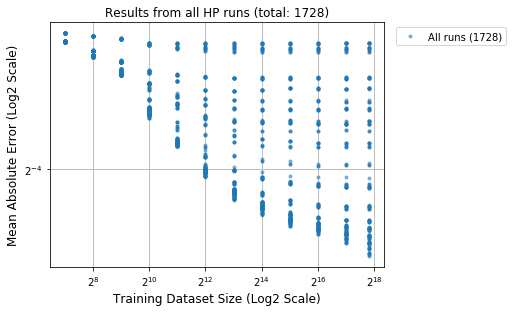

In [120]:
plot_all_from_hp_df(hp, **plot_all_kwargs, label='All runs');

## Compare PS-HPO and LS-HPO

In [121]:
plot_fit_kwargs = {'plot_fit': True, 'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

if 'nn' in str(base_dir):
    dflt_hp_dct = {'batch_size':32, 'batchnorm': True, 'dr_rate': 0.2, 'lr': 0.0001, 'opt': 'sgd'}
elif 'lgbm' in str(base_dir):
    dflt_hp_dct = {'gbm_leaves': 31, 'gbm_lr': 0.1, 'gbm_max_depth': -1, 'gbm_trees': 100}

### PS-HPO
Extract the best performance score for every shard (for each metric)

In [122]:
ps_best = hp.sort_values(met, ascending=True).drop_duplicates(['tr_size']).sort_values('tr_size').reset_index(drop=True)
ps_best

,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,100,0.01,-1,1000,128,0.107853,0.091761,0.068309
1,31,0.10,5,2000,256,0.101219,0.081071,0.140904
2,31,0.01,-1,2000,512,0.093330,0.071234,0.224569
3,10,0.01,10,2000,1024,0.077618,0.057756,0.463384
4,31,0.01,10,2000,2048,0.068957,0.049825,0.563311
5,50,0.01,-1,2000,4096,0.060487,0.043329,0.656461
6,100,0.01,-1,2000,8192,0.054837,0.038660,0.709462
7,100,0.01,-1,2000,16384,0.051387,0.035766,0.741045
8,100,0.01,10,2000,32768,0.048879,0.034062,0.763166
9,100,0.01,-1,2000,65536,0.047306,0.032852,0.777702


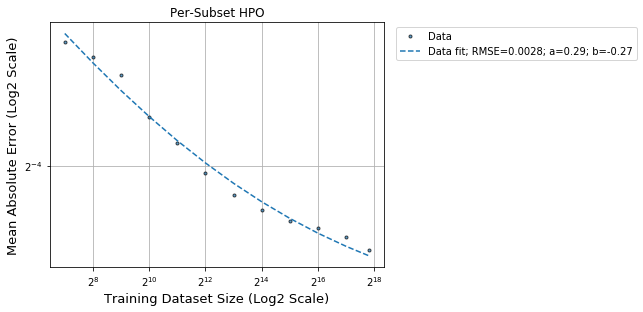

In [123]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ps_best['tr_size'], y = ps_best[met], title='Per-Subset HPO', **plot_fit_kwargs );

### LS-HPO
Extract the best performance score for the largest shard (for each metric)

In [124]:
best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric=met, plot=False)
display(best)

,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,100,0.1,-1,2000,230441,0.043069,0.030065,0.817472


In [125]:
if 'nn' in str(base_dir):
    prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
elif 'lgbm' in str(base_dir):
    prm_names = ['gbm_trees', 'gbm_max_depth', 'gbm_lr', 'gbm_leaves']

In [126]:
# idx = pd.Series(True, index=range(hp.shape[0]))
# for c in prm_names:  idx = idx & ( hp[c] == best[c][0] )
# ls_best = hp[ idx ].sort_values('tr_size').reset_index(drop=True)

hp_cols = [c for c in dflt_hp_dct.keys()]
ls_hp_best_dct = {c: best[c].values[0] for c in hp_cols}
ls_best = extract_runs_by_specific_hps(hp, ls_hp_best_dct) # hp_ls_best

ls_best.to_csv(base_dir/'hpo_ls_best.csv', index=False)
display(ls_best)


,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,100,0.1,-1,2000,128,0.108182,0.092402,0.066382
1,100,0.1,-1,2000,256,0.101871,0.082251,0.134349
2,100,0.1,-1,2000,512,0.094300,0.071182,0.202265
3,100,0.1,-1,2000,1024,0.081241,0.060637,0.413493
4,100,0.1,-1,2000,2048,0.070422,0.050829,0.543028
5,100,0.1,-1,2000,4096,0.062453,0.044219,0.634225
6,100,0.1,-1,2000,8192,0.056167,0.040080,0.699191
7,100,0.1,-1,2000,16384,0.052662,0.036963,0.731794
8,100,0.1,-1,2000,32768,0.049754,0.034858,0.756350
9,100,0.1,-1,2000,65536,0.047964,0.033538,0.772793


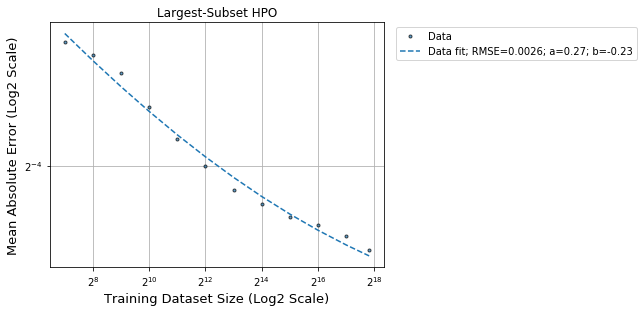

In [127]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ls_best['tr_size'], y = ls_best[met], title='Largest-Subset HPO', **plot_fit_kwargs );

### Plot all data points

In [128]:
hp_dflt = extract_runs_by_specific_hps(hp, dflt_hp_dct)
display(hp_dflt)


,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,31,0.1,-1,100,128,0.108182,0.092402,0.066382
1,31,0.1,-1,100,256,0.101871,0.082251,0.134349
2,31,0.1,-1,100,512,0.094300,0.071182,0.202265
3,31,0.1,-1,100,1024,0.080684,0.060358,0.416658
4,31,0.1,-1,100,2048,0.069589,0.050038,0.552855
5,31,0.1,-1,100,4096,0.062528,0.045835,0.640409
6,31,0.1,-1,100,8192,0.057397,0.041596,0.690571
7,31,0.1,-1,100,16384,0.054251,0.038652,0.719293
8,31,0.1,-1,100,32768,0.051967,0.036875,0.738987
9,31,0.1,-1,100,65536,0.050867,0.035780,0.747913


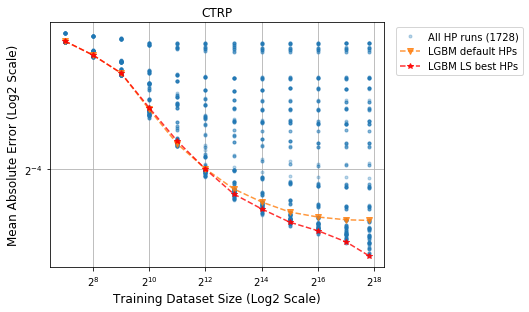

In [129]:
# matplotlib.org/3.1.0/api/markers_api.html#module-matplotlib.markers

# Plot all runs
ax = plot_all_from_hp_df(hp, **plot_all_kwargs, marker='.', alpha=0.3, title=f'{src.upper()}', label='All HP runs');

# Plot runs from default model HPs
ax.plot(hp_dflt['tr_size'], hp_dflt[met], ls='--', alpha=0.8, marker='v', label='LGBM default HPs');

# Plot runs from best LS-HPs applied to all shards
ax.plot(ls_best['tr_size'], ls_best[met], ls='--', color='r', alpha=0.8, marker='*', label='LGBM LS best HPs');

ax.legend(frameon=True, fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left');

### Percent improvement

In [130]:
# display(hp_dflt)
# display(ps_best)

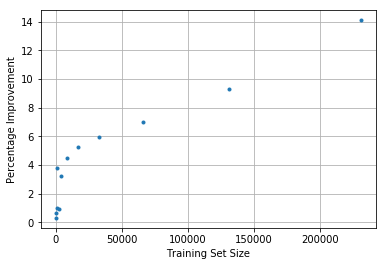

In [131]:
sizes = list(set(hp_dflt['tr_size']).intersection(set(ps_best['tr_size'])))
V0 = hp_dflt[ hp_dflt['tr_size'].isin(sizes) ]
V1 = ps_best[ ps_best['tr_size'].isin(sizes) ]

v0 = V0.loc[:,'mean_absolute_error']
v1 = V1.loc[:,'mean_absolute_error']
imp = (v0-v1)/v0*100

plt.plot(V0['tr_size'], imp, '.'); plt.grid(True);
plt.ylabel('Percentage Improvement')
plt.xlabel('Training Set Size');

### PS-HPO vs LS-HPO fit

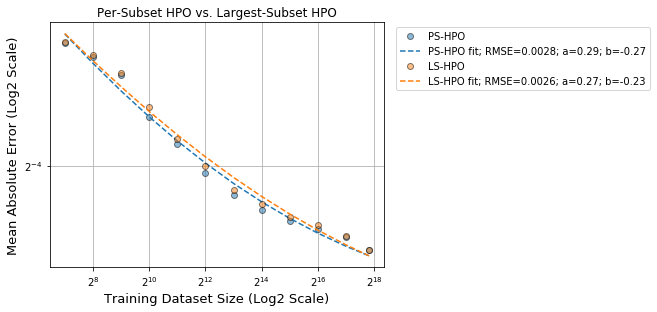

In [132]:
marker='o'; alpha=0.5

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ps_best['tr_size'], y=ps_best[met],
                                                         marker=marker, alpha=alpha, label='PS-HPO',
                                                         ax=None, **plot_fit_kwargs)

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ls_best['tr_size'], y=ls_best[met],
                                                         marker=marker, alpha=alpha, label='LS-HPO', 
                                                         ax=ax, **plot_fit_kwargs,
                                                         title='Per-Subset HPO vs. Largest-Subset HPO')

## PS-HPO vs LS-HPO extrapolate

In [133]:
m0 = 7

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3925682898>,
 {'alpha': 1.6237977297761375,
  'beta': -0.008721955468566307,
  'gamma': -1.4465587948241945})

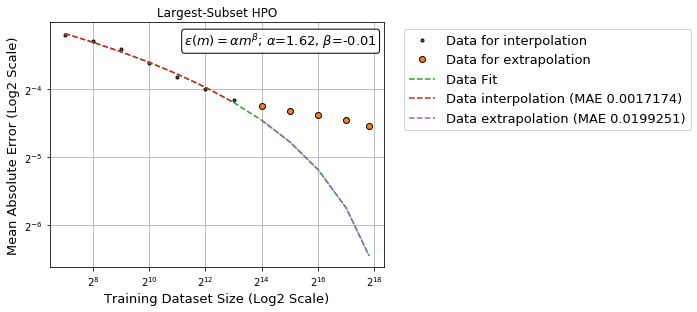

In [134]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ls_best['tr_size'], y=ls_best[met],
                                           m0=m0, **plot_fit_kwargs, title='Largest-Subset HPO')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f39255ed4a8>,
 {'alpha': 0.37512802043377136,
  'beta': -0.052148338785040056,
  'gamma': -0.1814039045886107})

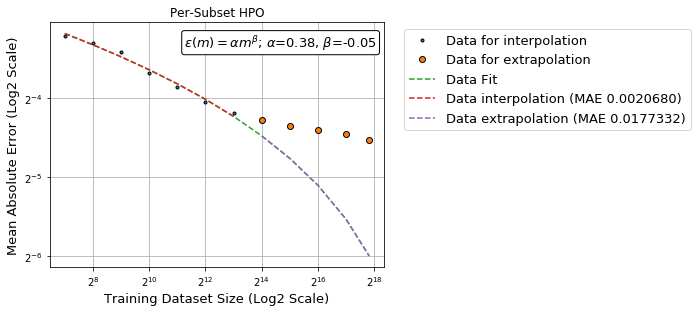

In [135]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ps_best['tr_size'], y=ps_best[met],
                                           m0=m0, **plot_fit_kwargs, title='Per-Subset HPO')